<a href="https://colab.research.google.com/github/manojan143/ML_Projects/blob/main/Project8_Wine_Type_Quality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from google.colab import files


In [ ]:
uploaded = files.upload()  # Upload your CSV file
import io
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]))
print("Dataset shape:", df.shape)
df.head()


Saving winequalityN.csv to winequalityN.csv
Dataset shape: (6497, 13)


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
# Basic info
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Histograms for all numeric features
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols].hist(figsize=(15,12), bins=20, color="skyblue")
plt.suptitle("Feature Distributions")
plt.show()

# Correlation heatmap (numeric only)
plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix (Numeric Only)")
plt.show()

# Pairplot sample for speed
sns.pairplot(df.sample(min(500,len(df))), hue=df.columns[0], diag_kind='kde')
plt.show()


In [ ]:
# Choose target: 'type' (binary) or 'quality' (multiclass)
target_col = 'type'
y = df[target_col]

# Encode target if string
if y.dtype=='object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Features
X = df.drop(columns=[target_col])
X = X.fillna(X.mean())  # handle missing numeric

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


Decision Tree Accuracy: 0.9815384615384616
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       320
           1       0.99      0.98      0.99       980

    accuracy                           0.98      1300
   macro avg       0.97      0.98      0.98      1300
weighted avg       0.98      0.98      0.98      1300



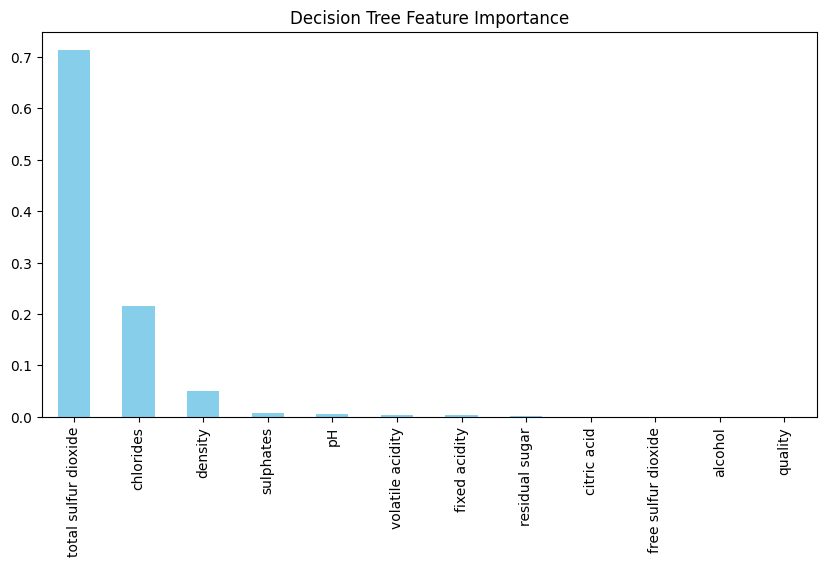

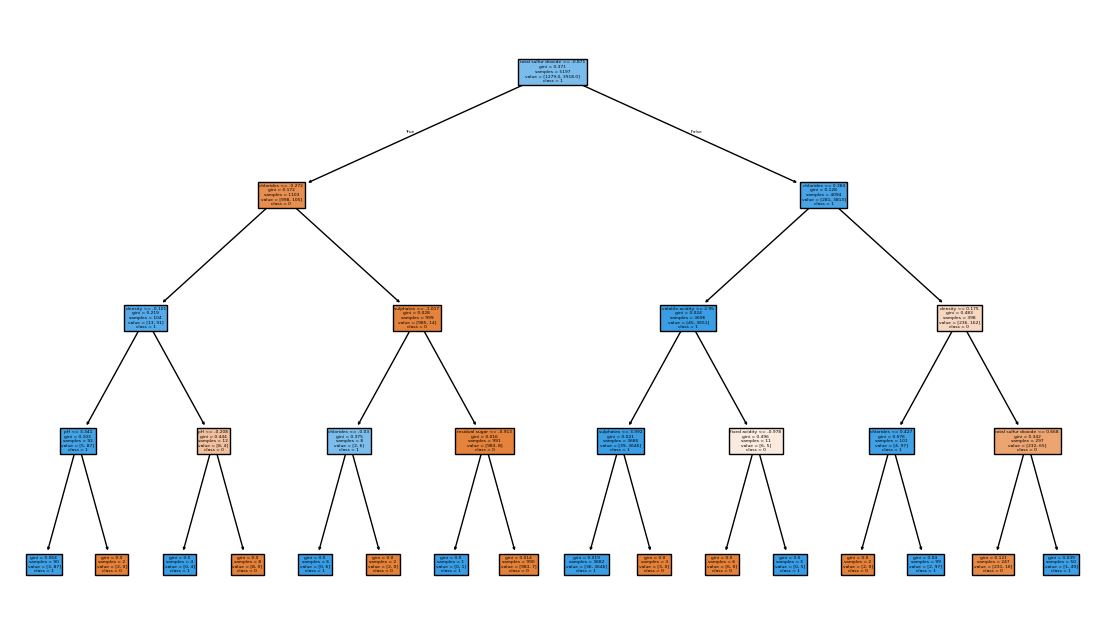

In [ ]:
dt = DecisionTreeClassifier(random_state=42, max_depth=4)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Metrics
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

# Feature importance
feat_imp = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,5))
feat_imp.plot(kind='bar', color='skyblue')
plt.title("Decision Tree Feature Importance")
plt.show()

# Tree visualization
plt.figure(figsize=(14,8))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=[str(c) for c in np.unique(y)])
plt.show()


In [ ]:
svm = SVC(kernel="rbf", C=1, gamma="scale")
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9969230769230769
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       320
           1       1.00      1.00      1.00       980

    accuracy                           1.00      1300
   macro avg       1.00      0.99      1.00      1300
weighted avg       1.00      1.00      1.00      1300



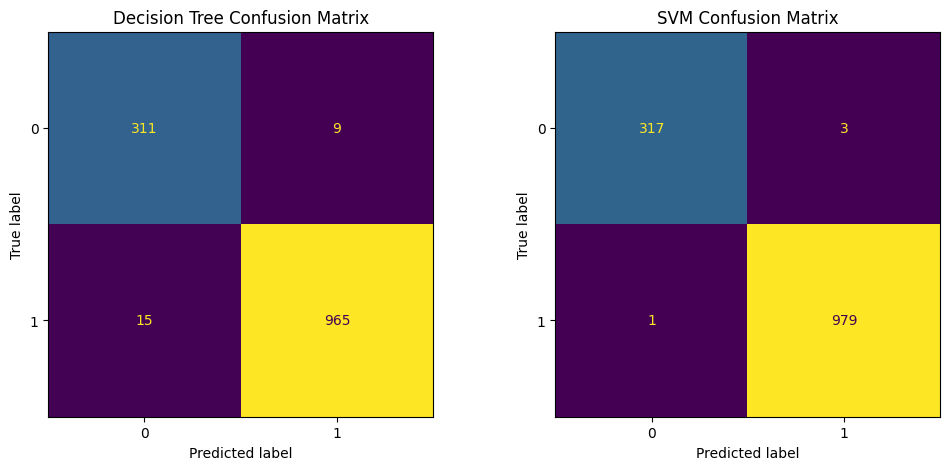

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dt), display_labels=np.unique(y)).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Decision Tree Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svm), display_labels=np.unique(y)).plot(ax=axes[1], colorbar=False)
axes[1].set_title("SVM Confusion Matrix")
plt.show()


In [ ]:
param_grid = {"C":[0.1,1,10], "kernel":["linear","rbf","poly"], "gamma":["scale","auto"]}
grid = GridSearchCV(SVC(), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best SVM Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Best SVM Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.9959593173909825


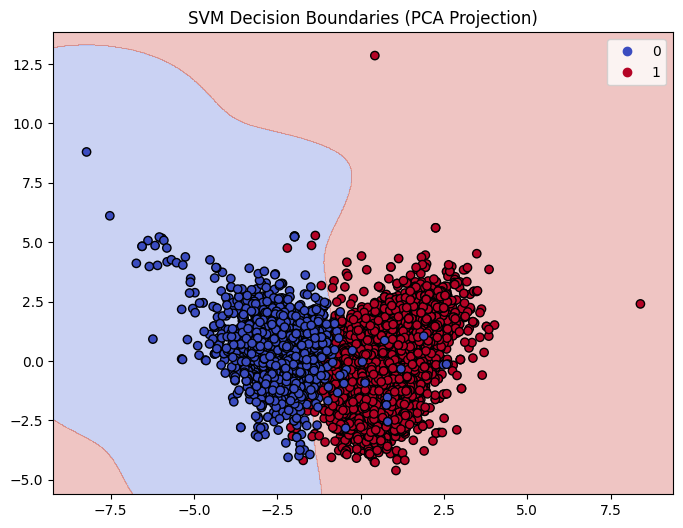

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

svm_vis = SVC(kernel="rbf", C=1, gamma="scale")
svm_vis.fit(X_pca, y)

# Decision boundary
x_min, x_max = X_pca[:,0].min()-1, X_pca[:,0].max()+1
y_min, y_max = X_pca[:,1].min()-1, X_pca[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min,x_max,0.02), np.arange(y_min,y_max,0.02))
Z = svm_vis.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap=plt.cm.coolwarm, edgecolors="k")
handles, _ = scatter.legend_elements()
plt.legend(handles=list(handles), labels=[str(c) for c in np.unique(y)])
plt.title("SVM Decision Boundaries (PCA Projection)")
plt.show()


In [ ]:
print("Decision Tree - Train:", accuracy_score(y_train, dt.predict(X_train)),
      "Test:", accuracy_score(y_test, y_pred_dt))
print("SVM - Train:", accuracy_score(y_train, svm.predict(X_train)),
      "Test:", accuracy_score(y_test, y_pred_svm))


Decision Tree - Train: 0.9874927842986339 Test: 0.9815384615384616
SVM - Train: 0.9965364633442371 Test: 0.9969230769230769


/tmp/ipython-input-907685294.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette="Set2")


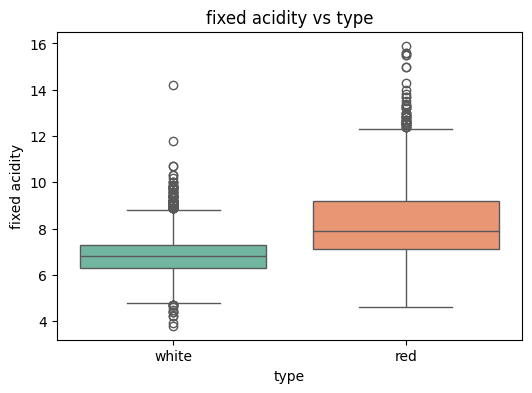

/tmp/ipython-input-907685294.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette="Set2")


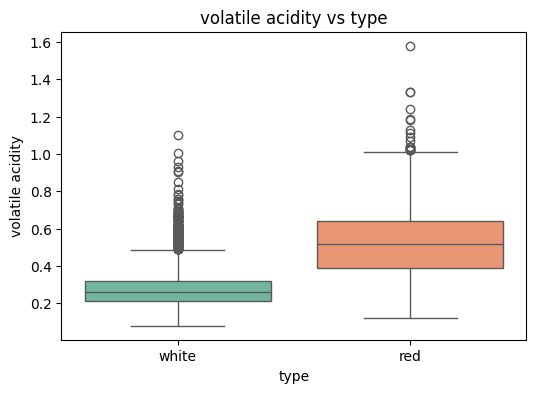

/tmp/ipython-input-907685294.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette="Set2")


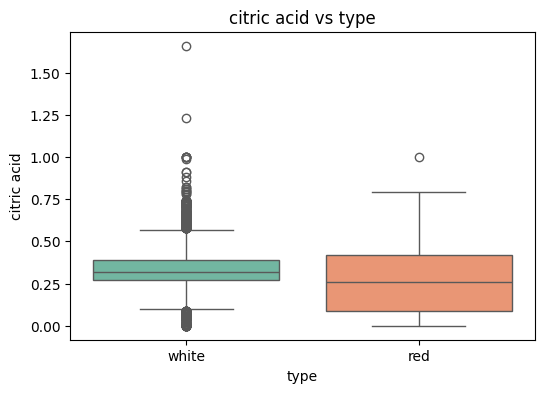

/tmp/ipython-input-907685294.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette="Set2")


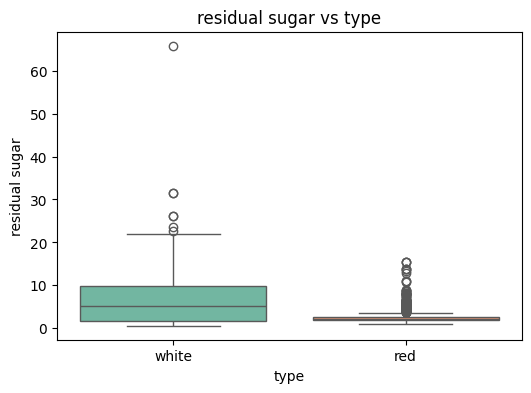

/tmp/ipython-input-907685294.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette="Set2")


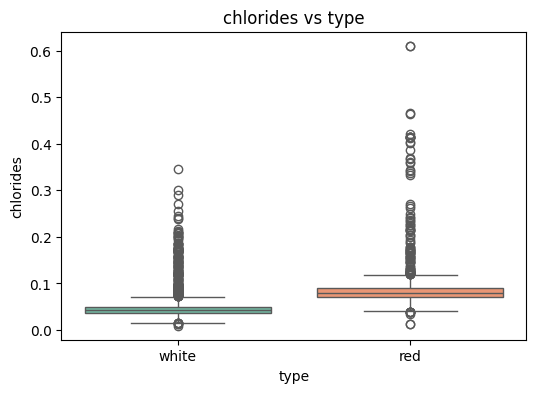

/tmp/ipython-input-907685294.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette="Set2")


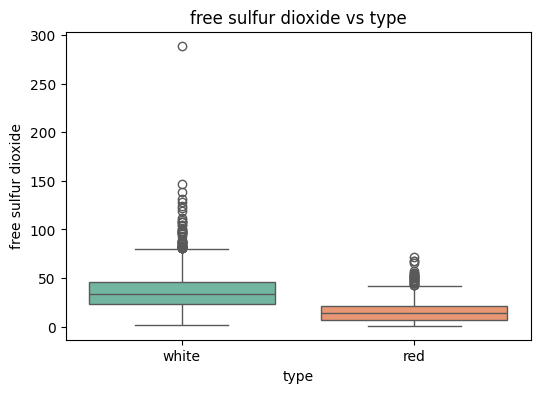

/tmp/ipython-input-907685294.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette="Set2")


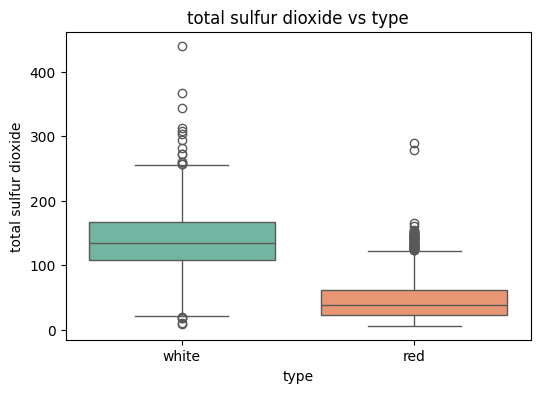

/tmp/ipython-input-907685294.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette="Set2")


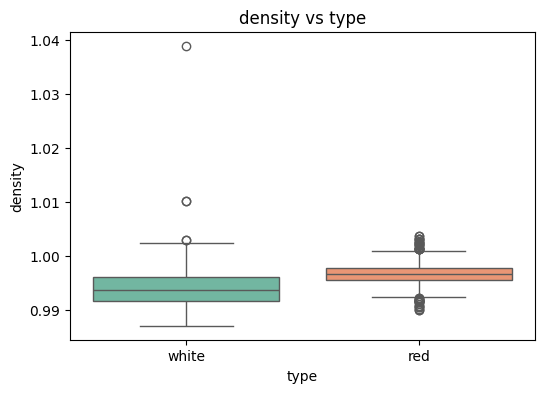

/tmp/ipython-input-907685294.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette="Set2")


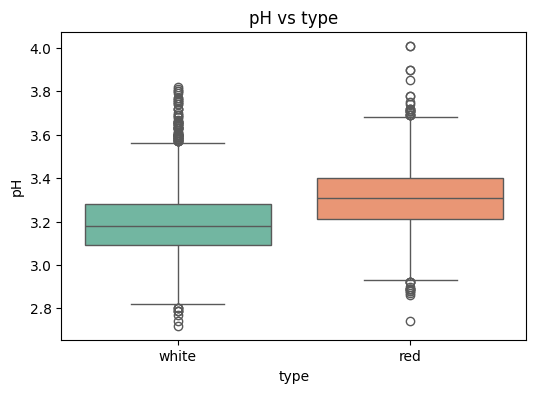

/tmp/ipython-input-907685294.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette="Set2")


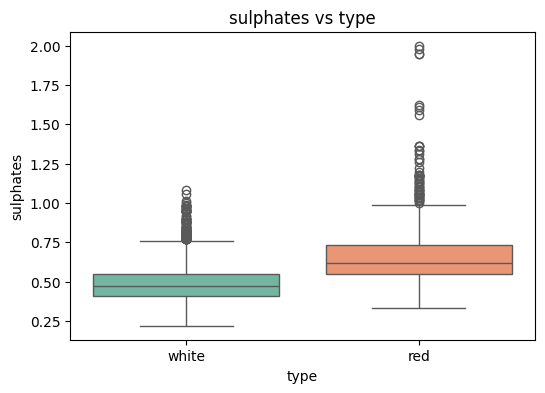

/tmp/ipython-input-907685294.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette="Set2")


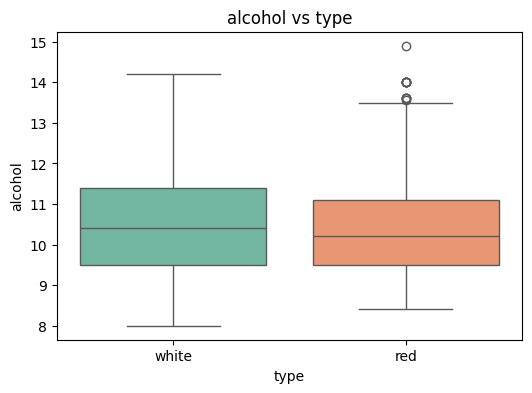

/tmp/ipython-input-907685294.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette="Set2")


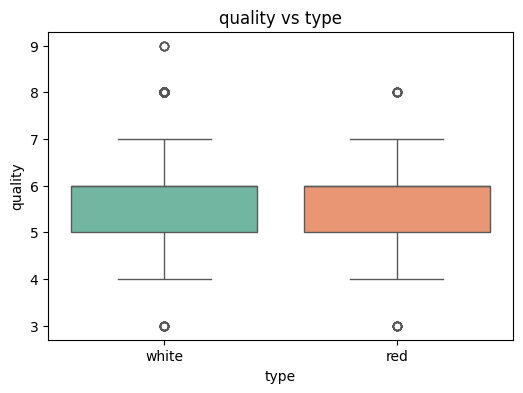

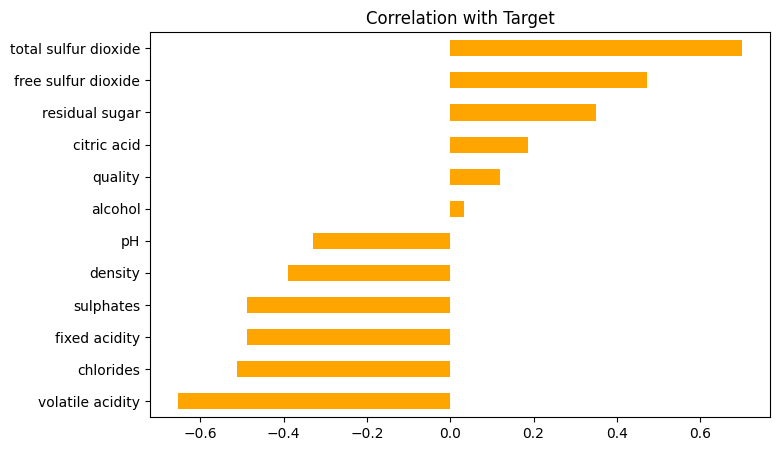

In [ ]:
# Boxplots for numeric features by target
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target_col, y=col, data=df, palette="Set2")
    plt.title(f"{col} vs {target_col}")
    plt.show()

# Correlation heatmap for target vs numeric features
corr_target = df[numeric_cols].corrwith(pd.Series(y))
plt.figure(figsize=(8,5))
corr_target.sort_values().plot(kind='barh', color='orange')
plt.title("Correlation with Target")
plt.show()


Original 10 questions:

What features distinguish wine types? → Feature importance + correlations + boxplots

How does SVM work? → SVM model training explained

What kernel is best? → Hyperparameter tuning with GridSearchCV

How to visualize decision boundaries? → PCA + SVM contour plot

What is feature scaling? → StandardScaler used before modeling

How to evaluate multiclass accuracy? → Classification report + accuracy score

What is confusion matrix? → Confusion matrices for DT and SVM

How to tune SVM parameters? → GridSearchCV

What is overfitting? → Train vs test accuracy comparison

How to compare models? → Accuracy bar chart

Extra 5 questions I added:

11. Histograms & pairplots → Visualize distributions & relationships
12. PCA 2D scatter → Dimensionality reduction + visualization
13. Correlation with target → Feature-target correlation bar chart
14. Boxplots for numeric features → Compare feature distributions by class
15. Feature importance plot for Decision Tree → Rank features